# <center>Welcome in Branch and Bound Applied to FSP</center>

In [85]:
import numpy as np
import itertools
import time
import math
import pandas as pd
import matplotlib.pyplot as plt

## Packages importing & data loading

In [86]:
'''
Reading the data from the benchmark file
'''

def read_flow_shop_data(file_path, machine_count, job_count):
    instances = []
    with open(file_path) as p:
        lines = p.readlines()
        line_count = len(lines)

        instance_count = line_count // (machine_count + 3)

        for i in range(instance_count):
            # recover the data of each instance
            params_line = lines[i * (machine_count + 3) + 1]
            job_count, machine_count, initial_seed, upper_bound, lower_bound = list(
                map(lambda x: int(x), params_line.split()))

            # processing_times = [list(map(int, lines[i * (machine_count + 3) + 3])) for line in lines]
            processing_times = np.array([list(map(lambda x: int(x), line.strip().split())) for
                                         line in lines[
                                                 i * (machine_count + 3) + 3:  # start
                                                 i * (machine_count + 3) + 3 + machine_count  # end
                                                 ]
                                         ])

            record = (machine_count, job_count, processing_times)
            instances.append(record)

    return instances



## Gantt graph generator

In [87]:
def generate_gantt_chart(current_instance, solution):
    plt.figure(figsize=(20, 12))
    df = pd.DataFrame(columns=['Machine', 'Job', 'Start', 'Finish'])

    machines, jobs = current_instance.shape
    machine_times = np.zeros((machines, jobs))
    start_time_m = np.zeros(machines)
    for job in solution:

        for machine_index in range(machines):
            start_time = start_time_m[machine_index]
            if machine_index > 0:
                start_time = max(start_time, start_time_m[machine_index-1])
            end_time = start_time + \
                current_instance[machine_index, job]
            start_time_m[machine_index] = end_time

            df = pd.concat([df, pd.DataFrame({'Machine': f'Machine {machine_index + 1}',
                                                'Job': f'Job {job + 1}',
                                                'Start': start_time,
                                                'Finish': end_time}, index=[0])], ignore_index=True)

            machine_times[machine_index, job] = end_time

    colors = plt.cm.tab10.colors
    for i, machine_index in enumerate(range(machines)):
        machine_df = df[df['Machine'] == f'Machine {machine_index + 1}']
        plt.broken_barh([(start, end - start) for start, end in zip(machine_df['Start'], machine_df['Finish'])],
                        (i * 10, 9), facecolors=[colors[j % 10] for j in range(jobs)], edgecolor='black')

    plt.xlabel('Time')
    plt.yticks([i * 10 + 4.5 for i in range(machines)],
                [f'Machine {i + 1}' for i in range(machines)])
    plt.show()

## Branch and Bound Implementation


### Path Cost calculation function :
used to calculate the cost of current node, which is the correct cost starting for the actual path of executed jobs

In [88]:
def incremental_cost(machine_job_matrix, jobs_sequence):
    nb_jobs = len(jobs_sequence)
    nb_machines = machine_job_matrix.shape[0]

    incremental_cost = np.zeros((nb_machines, nb_jobs))

    # evaluate the first machines
    incremental_cost[0, 0] = machine_job_matrix[0][jobs_sequence[0]]

    for i in range(1, nb_jobs):
        incremental_cost[0][i] = incremental_cost[0][i - 1] + \
            machine_job_matrix[0][jobs_sequence[i]]

    # evaluate the rest of machines
    for i in range(1, nb_machines):
        incremental_cost[i, 0] = incremental_cost[i - 1, 0] + \
            machine_job_matrix[i, jobs_sequence[0]]
        for j in range(1, nb_jobs):
            incremental_cost[i, j] = machine_job_matrix[i, jobs_sequence[j]] + \
                max(incremental_cost[i - 1, j], incremental_cost[i, j - 1])
    return incremental_cost.T

### Remaining jobs evaluation 
Used in order to evaluate the predicted cost of the current path's remaining jobs, when combined with the correct cost of the actual path, we will have a value with which we can impure a explore another branch

In [89]:
def evaluate_sequence(sequence, processing_times):

    machine_job_matrix = processing_times
    jobs_squence = sequence

    num_jobs, num_machines = machine_job_matrix.shape
    unhandeled_job = [  job for job  in range(num_jobs) if job not in jobs_squence]
    if not unhandeled_job : 
        return incremental_cost(machine_job_matrix.T, jobs_squence)[-1,-1]

    LBt = max(np.sum(machine_job_matrix, axis=0))
    LB1 = np.sum(machine_job_matrix[:, 0]) + min(np.sum(machine_job_matrix[unhandeled_job][:,1:] , axis=1) )
    lower_bounds = [0] * (num_machines - 1)
    
    if jobs_squence :
        CT = incremental_cost(machine_job_matrix.T, jobs_squence)
        
        
        
        for machine in range(1, num_machines):
            ct = CT[ -1 , machine]
            cost_unhandeled_job = np.sum(machine_job_matrix[unhandeled_job][:,machine])
            cost_last_job_las_machine = min(np.sum(
                machine_job_matrix[unhandeled_job][:, machine+1:], axis=1))if machine != num_machines - 1 else 0

            lower_bounds[machine - 1] = ct + cost_unhandeled_job + cost_last_job_las_machine
    else :
        for machine in range(1,num_machines):
            ct = 0
            cost_unhandeled_job = np.sum(
                machine_job_matrix[unhandeled_job][:, machine])
            cost_last_job_las_machine = min(np.sum(
                machine_job_matrix[unhandeled_job][:, machine+1:],axis=1)) if machine != num_machines - 1 else 0
            lower_bounds[machine - 1] = ct + cost_unhandeled_job + cost_last_job_las_machine

    return  max([LBt, LB1] + lower_bounds)

# Heuristics

## NEH Algorithm

In [90]:
def order_jobs_in_descending_order_of_total_completion_time(processing_times):
    total_completion_time = processing_times.sum(axis=1)
    return np.argsort(total_completion_time, axis=0).tolist()

In [91]:
def insertion(sequence, position, value):
    new_seq = sequence[:]
    new_seq.insert(position, value)
    return new_seq

In [92]:
def neh_algorithm(processing_times):
    ordered_sequence = order_jobs_in_descending_order_of_total_completion_time(processing_times)
    # Define the initial order
    J1, J2 = ordered_sequence[:2]
    sequence = [J1, J2] if evaluate_sequence([J1, J2], processing_times) < evaluate_sequence([J2, J1], processing_times) else [J2, J1]
    del ordered_sequence[:2]
    # Add remaining jobs
    for job in ordered_sequence:
        Cmax = float('inf')
        best_sequence = []
        for i in range(len(sequence)+1):
            new_sequence = insertion(sequence, i, job)
            Cmax_eval = evaluate_sequence(new_sequence, processing_times)
            if Cmax_eval < Cmax:
                Cmax = Cmax_eval
                best_sequence = new_sequence
        sequence = best_sequence
    return sequence, Cmax

## Johnson Algorithm

In [93]:
def johnson_method(processing_times):
    jobs, machines = processing_times.shape
    copy_processing_times = processing_times.copy()
    maximum = processing_times.max() + 1
    m1 = []
    m2 = []
    
    if machines != 2:
        raise Exception("Johson method only works with two machines")
        
    for i in range(jobs):
        minimum = copy_processing_times.min()
        position = np.where(copy_processing_times == minimum)
        
        if position[1][0] == 0:
            m1.append(position[0][0])
        else:
            m2.insert(0, position[0][0])
        
        copy_processing_times[position[0][0]] = maximum
        
    return m1+m2

In [94]:
# Generate a random example to work with 7 jobs and 2 machines
rnd_data = np.random.randint(size=(7,2), low=5, high=23)
print(rnd_data, "\n")

start_time = time.time()
sol = johnson_method(rnd_data)
elapsed_time = time.time() - start_time

print(f'Best sequence found by Johnson is {sol} with a makespan of {evaluate_sequence(sol, rnd_data)}')
print("Elapsed time:", elapsed_time, "seconds")

[[ 8 17]
 [14  6]
 [13  7]
 [14 17]
 [22 19]
 [18  5]
 [ 8 13]] 

Best sequence found by Johnson is [0, 6, 3, 4, 2, 1, 5] with a makespan of 102.0
Elapsed time: 0.0 seconds


## Tests utils

## Branch & Bound

here we have the definition of a node class, and the branch and bound algorithm, where we will use the incremental_cost calculation and the evaluation functions

In [95]:
class Node:
    def __init__(self, jobs, remaining_jobs, parent=None, lower_bound=0):
        self.jobs = jobs
        self.remaining_jobs = remaining_jobs
        self.parent = parent
        self.lower_bound = lower_bound

In [96]:
from queue import PriorityQueue


class PriorityQueueNode:
    def __init__(self, jobs, remaining_jobs, lower_bound):
        self.jobs = jobs
        self.remaining_jobs = remaining_jobs
        self.lower_bound = lower_bound

    def __lt__(self, other):
        return self.lower_bound < other.lower_bound


def branch_and_bound(processing_times, initial_cost):
    jobs, machines = processing_times.shape
    root_node = PriorityQueueNode([], set(range(jobs)), lower_bound=0)
    best_solution = None
    best_solution_cost = initial_cost
    nodes = PriorityQueue()
    nodes.put(root_node)
    i = 0

    while not nodes.empty():
        node = nodes.get()
        for job in sorted(node.remaining_jobs):
            child_jobs = node.jobs + [job]
            child_remaining_jobs = node.remaining_jobs - {job}
            child_lower_bound = evaluate_sequence(child_jobs, processing_times)

            if child_lower_bound >= best_solution_cost:
                continue

            if not child_remaining_jobs and child_lower_bound < best_solution_cost:
                best_solution = child_jobs
                best_solution_cost = child_lower_bound
            elif child_lower_bound < best_solution_cost:
                child_node = PriorityQueueNode(
                    child_jobs, child_remaining_jobs, lower_bound=child_lower_bound)
                nodes.put(child_node)
        i += 1

    return best_solution, best_solution_cost, i

## Tests Branch and bound

## Random instance

In [97]:
rnd_data = np.random.randint(size=(8,5), low=10, high=50)
print(rnd_data, "\n")

[[48 18 36 29 41]
 [25 44 16 17 36]
 [34 44 15 30 15]
 [13 13 43 27 18]
 [21 37 13 11 21]
 [26 26 30 36 27]
 [48 22 39 42 26]
 [31 36 13 29 49]] 



### Test with branch and bound

In [98]:
initial_solution = [i for i in range(8)]
initial_cost = evaluate_sequence(initial_solution, rnd_data)

start_time = time.time()
best_solution, best_cost, i = branch_and_bound(rnd_data, initial_cost)
elapsed_time = time.time() - start_time

print(f'Results of Branch & Bound:')
print(f'Best sequence is {best_solution} with a makespan of {best_cost}.')
print(f'No. Nodes visited is {i}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of Branch & Bound:
Best sequence is [3, 5, 1, 7, 6, 4, 0, 2] with a makespan of 351.0.
No. Nodes visited is 874.
Elapsed time of 0.34921693801879883 seconds.


### Test with NEH

In [99]:
initial_solution, initial_cost = neh_algorithm(rnd_data)

start_time = time.time()
best_solution, best_cost, i = branch_and_bound(rnd_data, initial_cost)
elapsed_time = time.time() - start_time

print(f'Results of Branch & Bound (with NEH Initialization):')
print(f'Best sequence is {best_solution} with a makespan of {best_cost}.')
print(f'No. Nodes visited is {i}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of Branch & Bound (with NEH Initialization):
Best sequence is [3, 5, 1, 7, 6, 4, 0, 2] with a makespan of 351.0.
No. Nodes visited is 565.
Elapsed time of 0.2569124698638916 seconds.


### Test with BruteForce

In [100]:
def all_permutations(iterable):
    permutations = list(itertools.permutations(iterable))
    permutations_as_lists = [list(p) for p in permutations]
    return permutations_as_lists

In [101]:
start_time = time.time()

best_cost = math.inf
best_solution = None
for i in all_permutations(range(8)):
    gg = evaluate_sequence(i,rnd_data)
    if gg < best_cost:
        best_cost = gg
        best_solution = i


elapsed_time = time.time() - start_time

print(f'Results of Branch & Bound (with BruteFroce):')
print(f'Best sequence is {best_solution} with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')



Results of Branch & Bound (with BruteFroce):
Best sequence is [3, 5, 1, 7, 6, 4, 0, 2] with a makespan of 351.0.
Elapsed time of 1.8338830471038818 seconds.


## Common Instance

In [102]:
instance_common = np.array([
    [71, 79, 85, 82, 83], 
    [84, 71, 66, 68, 81],
    [78, 81, 75, 72, 87],
    [78, 75, 66, 72, 88],
    [72, 88, 83, 85, 88],
    [86, 88, 79, 82, 78],
    [75, 66, 86, 78, 78],
    [80, 79, 66, 83, 78],
    [73, 73, 67, 77, 71],
    [80, 77, 83, 78, 67],
])

In [103]:
instance_common.shape

(10, 5)

In [104]:
initial_solution = [i for i in range(10)]
initial_cost = evaluate_sequence(initial_solution, instance_common)

start_time = time.time()
best_solution, best_cost, i = branch_and_bound(instance_common, initial_cost)
elapsed_time = time.time() - start_time

print(f'Results of Branch & Bound:')
print(f'Best sequence is {best_solution} with a makespan of {best_cost}.')
print(f'No. Nodes visited is {i}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of Branch & Bound:
Best sequence is [3, 2, 7, 6, 8, 0, 1, 4, 5, 9] with a makespan of 1102.0.
No. Nodes visited is 1140.
Elapsed time of 0.684481143951416 seconds.


## TESTS TAI Benchmark
We have taken two instances form the benchmark, tested them using i7 11nth generation with 16 ram

In [105]:
instances = read_flow_shop_data('./../data/tai20_5.txt', 5, 20)

## TEST instance 7

In [106]:

comman_instances = instances[6][2].T

In [107]:
comman_instances.shape

(20, 5)

In [108]:
initial_solution = [i for i in range(20)]
initial_cost = evaluate_sequence(initial_solution,  comman_instances)

start_time = time.time()
best_solution, best_cost, i = branch_and_bound(comman_instances, initial_cost)
elapsed_time = time.time() - start_time

print(f'Results of Branch & Bound:')
print(f'Best sequence is {best_solution} with a makespan of {best_cost}.')
print(f'No. Nodes visited is {i}.')
print(f'Elapsed time of {elapsed_time} seconds.')


Results of Branch & Bound:
Best sequence is [9, 1, 12, 0, 18, 16, 15, 19, 14, 2, 10, 3, 4, 13, 5, 7, 8, 11, 6, 17] with a makespan of 1234.0.
No. Nodes visited is 1531.
Elapsed time of 2.5758421421051025 seconds.


C:\Users\DSI\AppData\Local\Temp\ipykernel_22476\266832772.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Machine': f'Machine {machine_index + 1}',


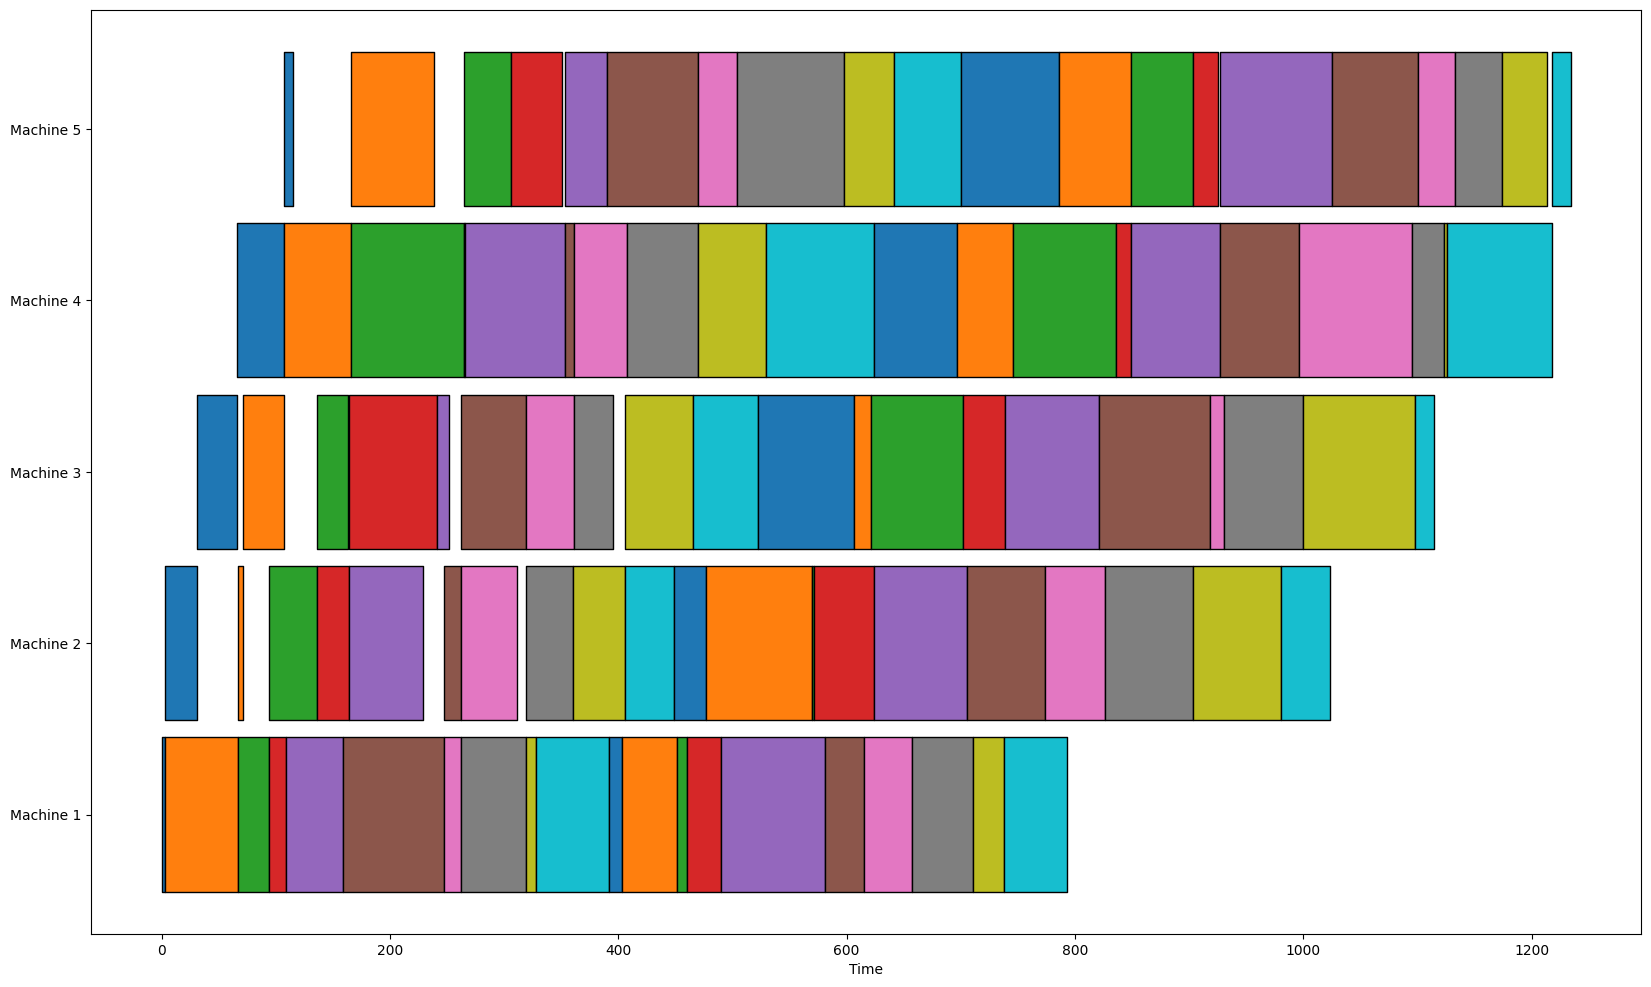

In [109]:
generate_gantt_chart(comman_instances.T, best_solution)

In [110]:

comman_instances = instances[1][2].T

In [111]:
initial_solution = [i for i in range(20)]
initial_cost = evaluate_sequence(initial_solution,  comman_instances)

start_time = time.time()
best_solution, best_cost, i = branch_and_bound(comman_instances, initial_cost)
elapsed_time = time.time() - start_time

print(f'Results of Branch & Bound:')
print(f'Best sequence is {best_solution} with a makespan of {best_cost}.')
print(f'No. Nodes visited is {i}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of Branch & Bound:
Best sequence is [5, 9, 16, 6, 18, 13, 8, 11, 17, 14, 12, 4, 15, 0, 2, 10, 19, 7, 3, 1] with a makespan of 1359.0.
No. Nodes visited is 2134.
Elapsed time of 3.9788737297058105 seconds.


C:\Users\DSI\AppData\Local\Temp\ipykernel_22476\266832772.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Machine': f'Machine {machine_index + 1}',


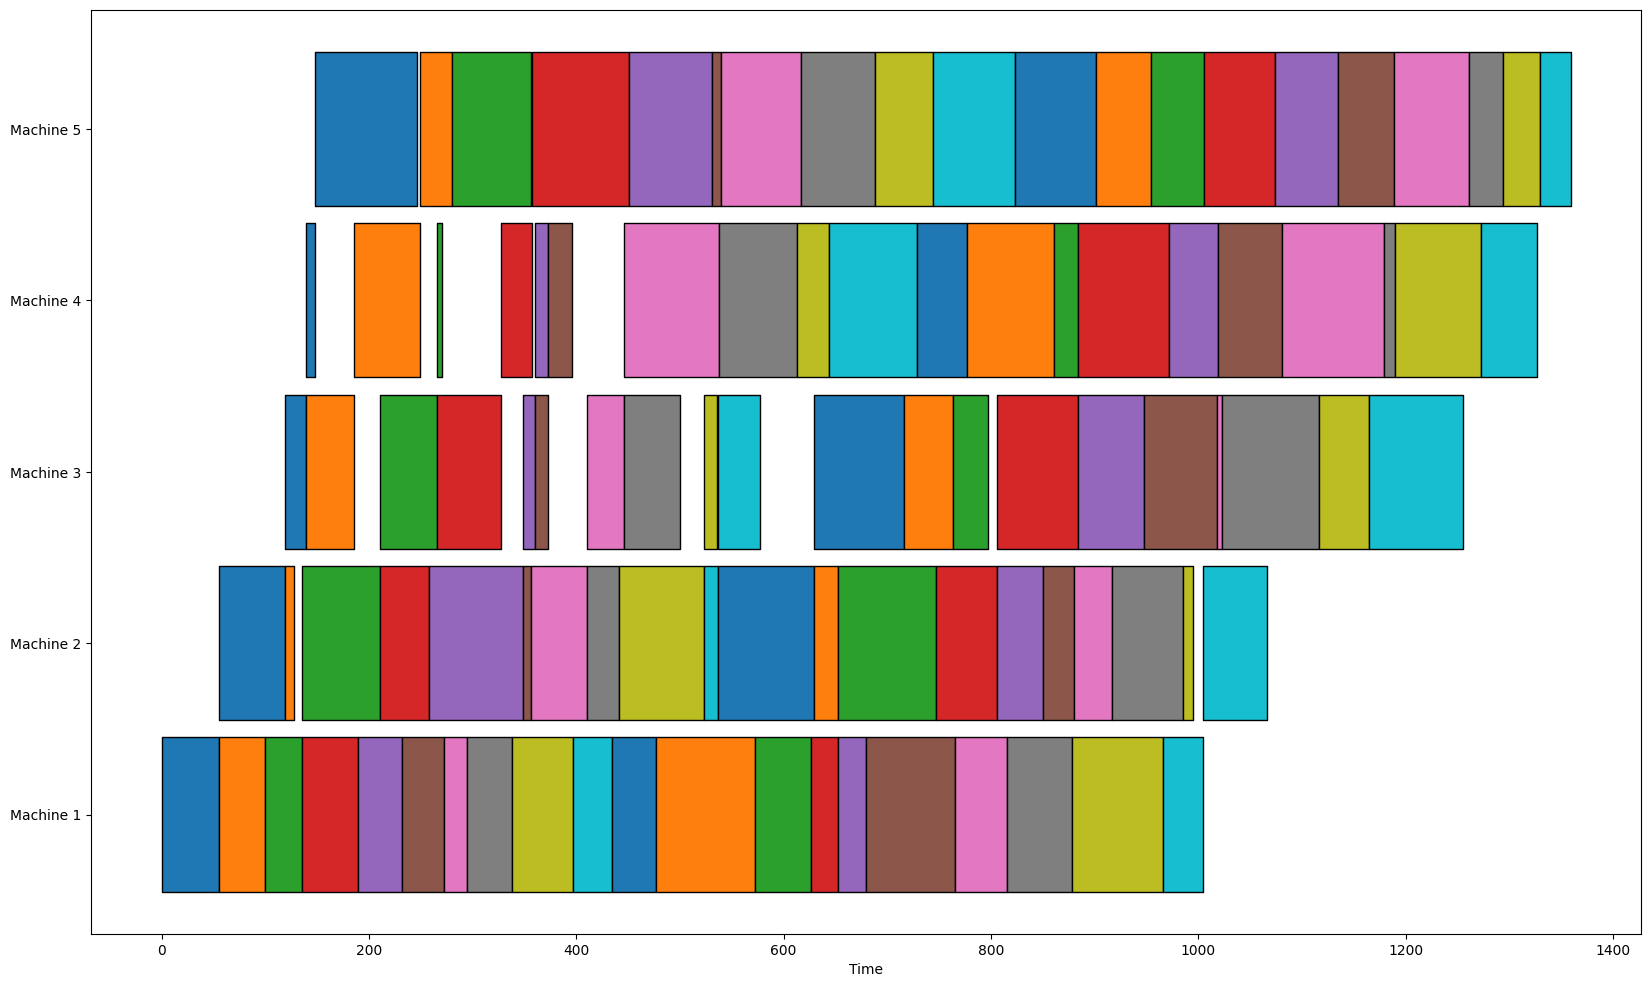

In [112]:
generate_gantt_chart(comman_instances.T, best_solution)